# Parametric Curve Fitting with Iterative Parametrization



A common task in geometric modeling is to fit a smooth curve to set of 3D points. The usual approach of fitting an explicit function to given data is indeed not usable here since it cannot represent vertical lines and is only single-valued. Therefore, we will look for a curve in parametric representation to approximate the given points.

The problem is to guess how the points are meant to be parametrized since it strongly affects the quality of approximation. This is a difficult problem that so far has not been solved in a satisfactory way (according to my knowledge). One of the possible methods, discussed in this article, is to iteratively modify the initial parametrization to minimize the error of approximation.

<img  src="parametric-curve-fitting/parametric_curve_approx_2.png" style="float:none"/>

<!-- TEASER_END -->

## 1 Introduction

Assume we have a sequence of $n$ knot points $\mathbf{P}_0,\dots,\mathbf{P}_{n-1}$, where $\mathbf{P}_i = (x_i, y_i, z_i)^T \in \mathbb{R}^3$. We want to associate them with parameter values $u_i$ and find an approximation curve in parametric representation

$$\mathbf{f}(u) = \begin{pmatrix} f_x(u) \\ f_y(u) \\ f_z(u) \end{pmatrix}.$$

For purpose of this article we will look for a parametric curve represented by polynomial functions of degree $k$, thus

$$ f_x(u)=\sum_{r=0}^{k} a_{x_r} u^r, \quad f_y(u)=\sum_{r=0}^{k} a_{y_r} u^r, \quad f_z(u)=\sum_{r=0}^{k} a_{z_r} u^r . $$

The goal of approximation is to find such curve $\mathbf{f}(u)$ that fits as close as possible to the knot points at parameter values $u_i$. This can be obtained by **_method of least-squares_**, which minimizes the sum of squares of residuals between the curve and given knot points. This approximation error can be formulated using Euclidean norm as

$$ S = \sum_{i=0}^{n-1} w_i \left[ (f_x(u_i) - x_i)^2 + (f_y(u_i) - y_i)^2 + (f_z(u_i) - z_i)^2 \right] = \sum_{i=0}^{n-1} w_i \|  \mathbf{f}(u_i) - \mathbf{P}_i \|^2, $$

where $w_i$ are values used to weight the "importance" of our knot points. For example, to achieve exact fit to the end-points, we just need to set weights for end-points significantly higher than for other points.



## 2 Initial Parametrization

We need to associate a parameter value $u_i$ to each knot point that will later be used to find the approximation curve. To obtain correct separation for all data, the values must be chosen that $u_i \leq u_{i+1},\, 0 \leq i \leq n-1$. Indeed, the best parametrization is unknown, but there are three simple methods how to obtain values for initial parametrization. 

- **Uniform parametrization**
$$u_i = \frac{i}{n-1}, \; i = 0, \dots, n-1$$

- **Chord-length parametrization**
$$u_0 = 0 \quad \mbox{and} \quad u_i = u_{i-1} + \frac{\|\mathbf{P}_i - \mathbf{P}_{i-1}\|}{\sum_{j=1}^{n-1} \|\mathbf{P}_j - \mathbf{P}_{j-1}\|}, \; i = 1, \dots, n-1$$

- **Centripetal parametrization**
$$u_0 = 0 \quad \mbox{and} \quad u_i = u_{i-1} + \frac{\|\mathbf{P}_i - \mathbf{P}_{i-1}\|^{1/2}}{\sum_{j=1}^{n-1} \|\mathbf{P}_j - \mathbf{P}_{j-1}\|^{1/2}}, \; i = 1, \dots, n-1$$


## 3 Algorithm

This approximation method can be split into two parts:

1. Given a set of $u$, compute approximation curve as polynimal functions $f_x(u),\,f_y(u),\,f_z(u)$ using **_method of least-squares_**.

2. Locally minimize the approximation error $s(u_i)$ for each value $u_i$ (excluding parameter values for end-points $u_0, u_{n-1}$ that we keep fixed), and continue with step 1.

Thus, each major iteration consists of $n-2$ minor iterations to find a new sequence of $u$. The contribution of $i^{th}$ point to the total approximation error is 

$$ s(u_i) = w_i \| \mathbf{f}(u_i) - \mathbf{P}_i \|^2,$$

and the new value of $u^*_i$ can be found as

$$ u^*_i =  \arg\!\min_u \left\{ w_i \| \mathbf{f}(u) - \mathbf{P}_i \|^2 \right\}, \; u_{i-1} \leq u \leq u_{i+1}.$$


### 3.1 Implementation Details

There are many numerical methods for finding the minimum of function. Comfortably we can use the **_golden section search_** method that iteratively narrowing the initial interval where the minimum exists.

The **_method of least-squares_** is already implemented in package NumPy as `numpy.polyfit` and can be used for fitting polynomial functions of desired degree.

The complete iterative algorithm is stopped when the reduction in $S$ in two successive iterations is less than a selected amount of precision or when predetermined number of iterations have been completed.




## 4 Implementation in Python

In [1]:
from numpy import *
from numpy.polynomial import polynomial as pl
from matplotlib.pyplot import *
from mpl_toolkits.mplot3d.axes3d import Axes3D

### 4.1 Generate 3D Points for Testing

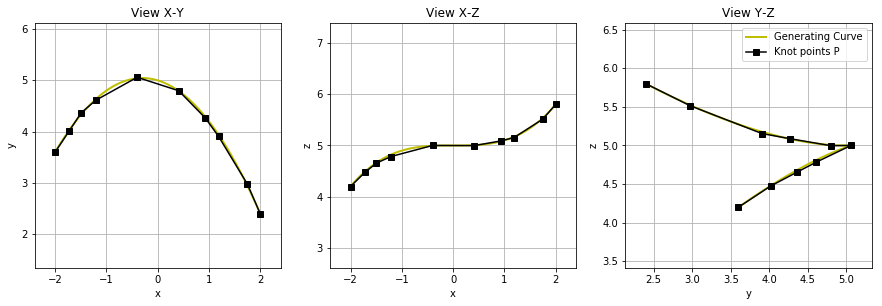

In [2]:
%matplotlib inline

#--- Generate y,z coords from given x coords
def generate_yz_coords(x):
    y = -0.5 * x**2 - 0.3 * x + 5
    z = 0.1 * x**3 + 5
    return y, z

#--- Generate and store knot points in matrix P
x = linspace(-2, 2, 16)
x = delete(x, [4,5,7,8,10,13])
y, z = generate_yz_coords(x)
n = len(x)
P = zeros([n,3])
P[:,0] = x
P[:,1] = y
P[:,2] = z

#--- Add some random noise to knot points excl. end-points
P[range(1,n-1),:] += random.normal(size=(n-2,3)) * 0.02

#--- Calculate some points to display the generating curve
x_gen = linspace(-2, 2, 50)
y_gen, z_gen = generate_yz_coords(x_gen)
P_gen = zeros([len(x_gen),3])
P_gen[:,0] = x_gen
P_gen[:,1] = y_gen
P_gen[:,2] = z_gen

#--- Plot
f, ax = subplots(1, 3, figsize=(15,4.5))
i = 0
ax[i].plot(P_gen[:,0], P_gen[:,1], 'y-', lw=2 ,label='Generating Curve')
ax[i].plot(P[:,0], P[:,1], 'ks-', label='Knot points P')
ax[i].set_title('View X-Y')
ax[i].set_xlabel('x'); ax[i].set_ylabel('y');
ax[i].set_aspect('equal', 'datalim')
ax[i].margins(.1, .1)
ax[i].grid()
i = 1
ax[i].plot(P_gen[:,0], P_gen[:,2], 'y-', lw=2 ,label='Generating Curve')
ax[i].plot(P[:,0], P[:,2], 'ks-', label='Knot points P')
ax[i].set_title('View X-Z')
ax[i].set_xlabel('x'); ax[i].set_ylabel('z'); 
ax[i].set_aspect('equal', 'datalim')
ax[i].margins(.1, .1)
ax[i].grid()
i = 2
ax[i].plot(P_gen[:,1], P_gen[:,2], 'y-', lw=2 ,label='Generating Curve')
ax[i].plot(P[:,1], P[:,2], 'ks-', label='Knot points P')
ax[i].set_title('View Y-Z')
ax[i].set_xlabel('y'); ax[i].set_ylabel('z'); 
ax[i].set_aspect('equal', 'datalim')
ax[i].margins(.1, .1)
ax[i].legend()
ax[i].grid()


### 4.2 Initial Parametrizations

In [3]:
def uniform_param(P):
    u = linspace(0, 1, len(P))
    return u
    
def chordlength_param(P):
    u = generate_param(P, alpha=1.0)
    return u
    
def centripetal_param(P):
    u = generate_param(P, alpha=0.5)
    return u
    
def generate_param(P, alpha):
    n = len(P)
    u = zeros(n)
    u_sum = 0
    for i in range(1,n):
        u_sum += linalg.norm(P[i,:]-P[i-1,:])**alpha
        u[i] = u_sum
    
    return u/max(u)

### 4.3 Golden Section Search Method

In [4]:
#-------------------------------------------------------------------------------
# Find Minimum by Golden Section Search Method
# - Return x minimizing function f(x) on interval a,b
#-------------------------------------------------------------------------------
def find_min_gss(f, a, b, eps=1e-4):
    
    # Golden section: 1/phi = 2/(1+sqrt(5))
    R = 0.61803399
    
    # Num of needed iterations to get precision eps: log(eps/|b-a|)/log(R)
    n_iter = int(ceil(-2.0780869 * log(eps/abs(b-a))))
    c = b - (b-a)*R
    d = a + (b-a)*R

    for i in range(n_iter):
        if f(c) < f(d):
            b = d
        else:
            a = c
        c = b - (b-a)*R
        d = a + (b-a)*R

    return (b+a)/2

### 4.4 Iterative Parametrization

In [5]:
def iterative_param(P, u, fxcoeff, fycoeff, fzcoeff, fig_ax):
    
    global iter_i, plt_color
    u_new = u.copy()
    f_u = zeros(3)

    #--- Calculate approx. error s(u) related to point P_i
    def calc_s(u):
        f_u[0] = pl.polyval(u, fxcoeff)
        f_u[1] = pl.polyval(u, fycoeff)
        f_u[2] = pl.polyval(u, fzcoeff)

        s_u = linalg.norm(P[i]-f_u)
        return s_u
    
    #--- Find new values u that locally minimising the approximation error (excl. fixed end-points)
    for i in range(1, len(u)-1):
        
        #--- Find new u_i minimising s(u_i) by Golden search method
        u_new[i] = find_min_gss(calc_s, u[i-1], u[i+1])
        
        #--- Sample some values bewteen u[i-1] and u[i+1] to plot graph
        u_samp = linspace(u[i-1], u[i+1], 25)
        
        x = pl.polyval(u_samp, fxcoeff)
        y = pl.polyval(u_samp, fycoeff)
        z = pl.polyval(u_samp, fzcoeff)

        residual = P[i] - array([x,y,z]).T
        s_u_samp = [linalg.norm(residual[j]) for j in range(len(u_samp))]
        
        #--- Plot error to given axes
        fig_ax.plot(u_samp, s_u_samp, color=plt_color[iter_i], alpha=plt_alpha)
        fig_ax.plot(u_new[i], calc_s(u_new[i]), 'o', color=plt_color[iter_i], alpha=plt_alpha)
        
    return u_new

### 4.5 Testing the Method

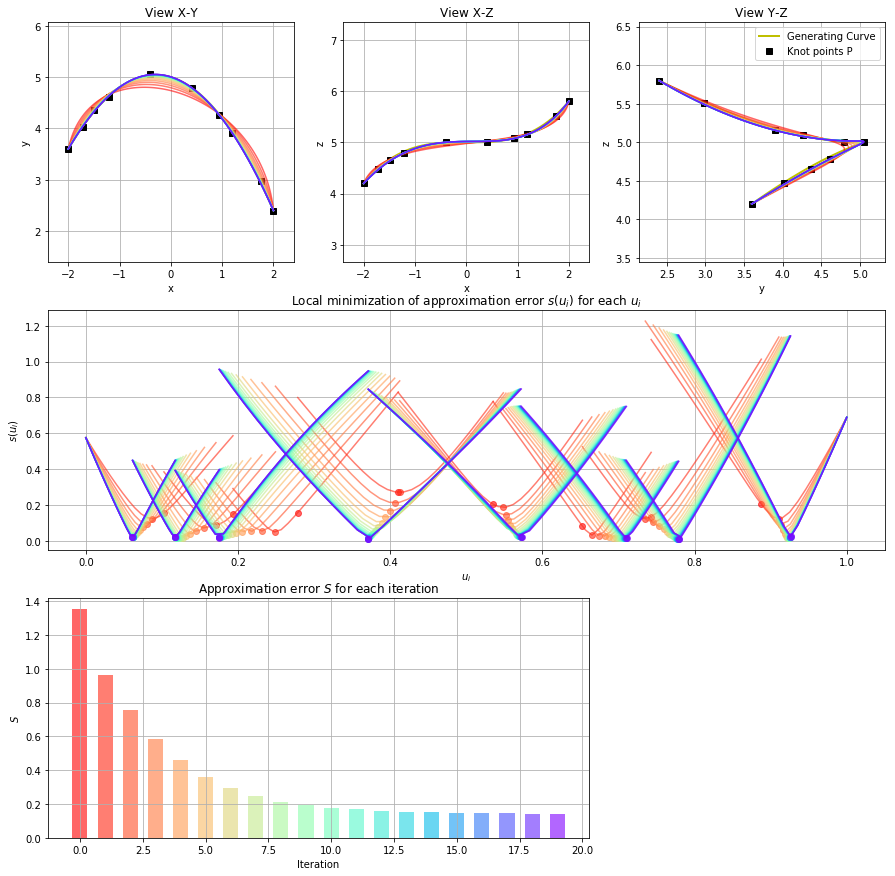

In [6]:
%matplotlib inline

#-------------------------------------------------------------------------------
# Options for the approximation method
#-------------------------------------------------------------------------------
polydeg = 3           # Degree of polygons of parametric curve
w = ones(n)           # Set weights for knot points
w[0] = w[-1] = 1e6
max_iter = 20         # Max. number of iterations
eps = 1e-3
plt_alpha = 0.6
plt_color = cm.rainbow(linspace(1,0,max_iter))

#-------------------------------------------------------------------------------
# Init variables
#-------------------------------------------------------------------------------
f_u = zeros([n,3])
uu = linspace(0,1,100)
f_uu = zeros([len(uu),3])
S_hist = []

#-------------------------------------------------------------------------------
# Init figures
#-------------------------------------------------------------------------------
fig = figure(figsize=(15,15))
figshape = (3,3)
ax = [None]*5
ax[0] = subplot2grid(figshape, loc=(0,0))
ax[1] = subplot2grid(figshape, loc=(0,1))
ax[2] = subplot2grid(figshape, loc=(0,2))
ax[3] = subplot2grid(figshape, loc=(1,0), colspan=3)
ax[4] = subplot2grid(figshape, loc=(2,0), colspan=2)
i = 0
ax[i].plot(P_gen[:,0], P_gen[:,1], 'y-', lw=2 ,label='Generating Curve')
ax[i].plot(P[:,0], P[:,1], 'ks', label='Knot points P')
ax[i].set_title('View X-Y')
ax[i].set_xlabel('x'); ax[i].set_ylabel('y');
ax[i].set_aspect('equal', 'datalim')
ax[i].margins(.1, .1)
ax[i].grid()
i = 1
ax[i].plot(P_gen[:,0], P_gen[:,2], 'y-', lw=2 ,label='Generating Curve')
ax[i].plot(P[:,0], P[:,2], 'ks', label='Knot points P')
ax[i].set_title('View X-Z')
ax[i].set_xlabel('x'); ax[i].set_ylabel('z'); 
ax[i].set_aspect('equal', 'datalim')
ax[i].margins(.1, .1)
ax[i].grid()
i = 2
ax[i].plot(P_gen[:,1], P_gen[:,2], 'y-', lw=2 ,label='Generating Curve')
ax[i].plot(P[:,1], P[:,2], 'ks', label='Knot points P')
ax[i].set_title('View Y-Z')
ax[i].set_xlabel('y'); ax[i].set_ylabel('z'); 
ax[i].set_aspect('equal', 'datalim')
ax[i].margins(.1, .1)
ax[i].legend()
ax[i].grid()
i = 3
ax[i].set_title('Local minimization of approximation error $s(u_i)$ for each $u_i$')
ax[i].set_xlabel('$u_i$'); ax[i].set_ylabel('$s(u_i)$');
ax[i].grid()
i = 4
ax[i].set_title('Approximation error $S$ for each iteration')
ax[i].set_xlabel('Iteration'); ax[i].set_ylabel('$S$');
ax[i].grid()

#-------------------------------------------------------------------------------
# Compute the iterative approximation
#-------------------------------------------------------------------------------
for iter_i in range(max_iter):

    #--- Initial or iterative parametrization
    if iter_i == 0:
        #u = uniform_param(P)
        #u = chordlength_param(P)
        u = centripetal_param(P)
    else:
        u = iterative_param(P, u, fxcoeff, fycoeff, fzcoeff, ax[3])
    
    #--- Compute polynomial approximations and get their coefficients
    fxcoeff = pl.polyfit(u, P[:,0], polydeg, w=w)
    fycoeff = pl.polyfit(u, P[:,1], polydeg, w=w)
    fzcoeff = pl.polyfit(u, P[:,2], polydeg, w=w)
    
    #--- Calculate function values f(u)=(fx(u),fy(u),fz(u))
    f_u[:,0] = pl.polyval(u, fxcoeff)
    f_u[:,1] = pl.polyval(u, fycoeff)
    f_u[:,2] = pl.polyval(u, fzcoeff)
    
    #--- Calculate fine values for ploting
    f_uu[:,0] = pl.polyval(uu, fxcoeff)
    f_uu[:,1] = pl.polyval(uu, fycoeff)
    f_uu[:,2] = pl.polyval(uu, fzcoeff)

    #--- Print plots
    hp = ax[0].plot(f_uu[:,0], f_uu[:,1], color=plt_color[iter_i], alpha=plt_alpha)
    hp = ax[1].plot(f_uu[:,0], f_uu[:,2], color=plt_color[iter_i], alpha=plt_alpha)
    hp = ax[2].plot(f_uu[:,1], f_uu[:,2], color=plt_color[iter_i], alpha=plt_alpha)
    
    #--- Errors of init parametrization
    if iter_i == 0:
        for i in range(1, len(u)-1):
            ax[3].plot(u[i], linalg.norm(P[i]-f_u[i]), 'o', color=plt_color[iter_i], alpha=plt_alpha)
    
    #--- Total error of approximation S for iteration i
    S = 0
    for j in range(len(u)):
        S += w[j] * linalg.norm(P[j] - f_u[j])
    
    #--- Add bar of approx. error
    ax[4].bar(iter_i, S, width=0.6, color=plt_color[iter_i], alpha=plt_alpha)
    S_hist.append(S)
    
    #--- Stop iterating if change in error is lower than desired condition
    if iter_i > 0:
        S_change = S_hist[iter_i-1] / S_hist[iter_i] - 1
        #print('iteration:%3i, approx.error: %.4f (%f)' % (iter_i, S_hist[iter_i], S_change))
        if S_change < eps:
            break
   

### 4.6 Display Results in 3D

In [ ]:
%matplotlib

#-------------------------------------------------------------------------------
# - Make axes of 3D plot to have equal scales
# - This is a workaround to Matplotlib's set_aspect('equal') and axis('equal')
#   which were not working for 3D
#-------------------------------------------------------------------------------
def set_axes_equal_3d(ax):
    limits = array([ax.get_xlim3d(), ax.get_ylim3d(), ax.get_zlim3d()])
    spans = abs(limits[:,0] - limits[:,1])
    centers = mean(limits, axis=1)
    radius = 0.5 * max(spans)
    ax.set_xlim3d([centers[0]-radius, centers[0]+radius])
    ax.set_ylim3d([centers[1]-radius, centers[1]+radius])
    ax.set_zlim3d([centers[2]-radius, centers[2]+radius])

#--- 3D Plot
fig = figure(figsize=(14,10))
ax = fig.add_subplot(1,1,1,projection='3d')

ax.plot(*P_gen.T, color='y', lw=4, label='Generating Curve')
ax.plot(*P.T, color='k', ls='--', marker='s', label='Knot points P')
ax.plot(*f_uu.T, color='b', ls='-', lw=3, label='Approximation Curve')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()
ax.set_aspect('equal', 'datalim')
set_axes_equal_3d(ax)

<img  src="parametric-curve-fitting/result_01.png" style="float:none"/>

## 5 Conclusion

We generated a set of 3D points using a generating curve and added some random noise. Then we tested the described curve fitting method with iterative parametrization, and we verified it gives significantly better approximation than using any initial parametrization only. The contribution to approximation error from each parameter $u_i$ seem to be unimodal function, thus it is easy to find minimum. Thanks to that, the convergence of this method is reasonably fast as we can see from the figure of the total approximation error. On other figures, it's also visible how closely the approximation curve fits and overlaps the generating curve.



### References

- [Parametric curves](https://en.wikipedia.org/wiki/Parametric_equation)
- [Least squares](https://en.wikipedia.org/wiki/Least_squares)
- [Golden section search](https://en.wikipedia.org/wiki/Golden_section_search)
- M. Grossman: *Parametric Curve Fitting*, The Computer Journal, 1971
- T. Lyche, K. Mørken: *Spline Methods*, Centre of Mathematics for Applications, University of Oslo, 2008
